# AlexNet Parallel GPU implementation

Here we will have a columnar implementation rather than a single column implementation. This can be achieved using the Functional API of Tensorflow v2.2 so we will use that to create 2 columns in the same architecture

## Model

<img src='architecture.jpg'/>

In [1]:
import tensorflow as tf
from tensorflow import keras

In [8]:
def get_alexnet_model(input_shape):
    
    
    def add_reponse_normalization(prev_layer):
        # add response normalization logic
        return prev_layer
    
    def add_cnn(prev_layer, kernels, shape, stride=(1,1), activation='relu', initial_bias='ones'):
        return keras.layers.Conv2D(kernels, shape, activation=activation, strides=stride,
                                   bias_initializer=initial_bias, kernel_initializer='he_normal')(prev_layer)
    
    def add_max_pooling(prev_layer, shape=(3,3), stride=(2,2)):
        return keras.layers.MaxPool2D(shape, strides=stride)(prev_layer)
    
    def add_dense(prev_layer, nodes, activation='relu', dropout=0.5, initial_bias='ones'):
        dense = keras.layers.Dense(nodes, activation=activation, 
                                   bias_initializer=initial_bias, kernel_initializer='he_normal')(prev_layer)
        if dropout != 0:
            dropout = keras.layers.Dropout(dropout)(dense)
            return dropout
        else:
            return dense

    def add_layer_with_rn_mp(prev_layer, cnn_kernels, cnn_kernel_shape, cnn_stride=(1,1), initial_bias='ones',
                             max_pool_kernel_shape=(3,3), max_pool_stride=(2,2)):
        cnn_layer = add_cnn(prev_layer, cnn_kernels, cnn_kernel_shape, cnn_stride, initial_bias=initial_bias)
        rn_layer = add_reponse_normalization(cnn_layer)
        mp_layer = add_max_pooling(rn_layer, max_pool_kernel_shape, max_pool_stride)
        return mp_layer
    
    def add_layer_with_mp(prev_layer, cnn_kernels, cnn_kernel_shape, cnn_stride=(1,1), intial_bias='ones', 
                          max_pool_kernel_shape=(3,3), max_pool_stride=(2,2)):
        cnn_layer = add_cnn(prev_layer, cnn_kernels, cnn_kernel_shape, cnn_stride, initial_bias=intial_bias)
        mp_layer = add_max_pooling(cnn_layer, max_pool_kernel_shape, max_pool_stride)
        return mp_layer
    
    inputs = keras.Input(shape=input_shape)
    
    layer1_1 = add_layer_with_rn_mp(inputs, 48, (11, 11), (4, 4), initial_bias=keras.initializers.zeros())
    layer1_2 = add_layer_with_rn_mp(inputs, 48, (11, 11), (4, 4), initial_bias=keras.initializers.zeros())
    
    layer2_1 = add_layer_with_rn_mp(layer1_1, 128, (5,5))
    layer2_2 = add_layer_with_rn_mp(layer1_2, 128, (5,5))
    
    layer2_concatenate_output = keras.layers.Concatenate()([layer2_1, layer2_2])
    
    layer3_1 = add_cnn(layer2_concatenate_output, 192, (3, 3), initial_bias=keras.initializers.zeros())
    layer3_2 = add_cnn(layer2_concatenate_output, 192, (3, 3), initial_bias=keras.initializers.zeros())
    
    layer4_1 = add_cnn(layer3_1, 192, (3, 3))
    layer4_2 = add_cnn(layer3_2, 192, (3, 3))
    
    layer5_1 = add_layer_with_mp(layer4_1, 192, (3, 3))
    layer5_2 = add_layer_with_mp(layer4_2, 192, (3, 3))
    
    layer6_1 = add_dense(layer5_1, 2048)
    layer6_2 = add_dense(layer5_2, 2048)
    
    layer7_1 = add_dense(layer6_1, 2048)
    layer7_2 = add_dense(layer6_2, 2048)
    
    layer7_concatenate_output = keras.layers.Concatenate()([layer7_1, layer7_2])
    
    layer8 = add_dense(layer7_concatenate_output, 1000, activation='softmax', dropout=0)
    
    model = keras.Model(inputs=inputs, outputs=layer8, name='sbjr_alexnet_implementation')
    return model
    

In [9]:
alexnet = get_alexnet_model((224, 224, 3))

In [10]:
alexnet.summary()

Model: "sbjr_alexnet_implementation"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 54, 54, 48)   17472       input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 54, 54, 48)   17472       input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 26, 26, 48)   0           conv2d_10[0][0]                  
________________________________________________________________________

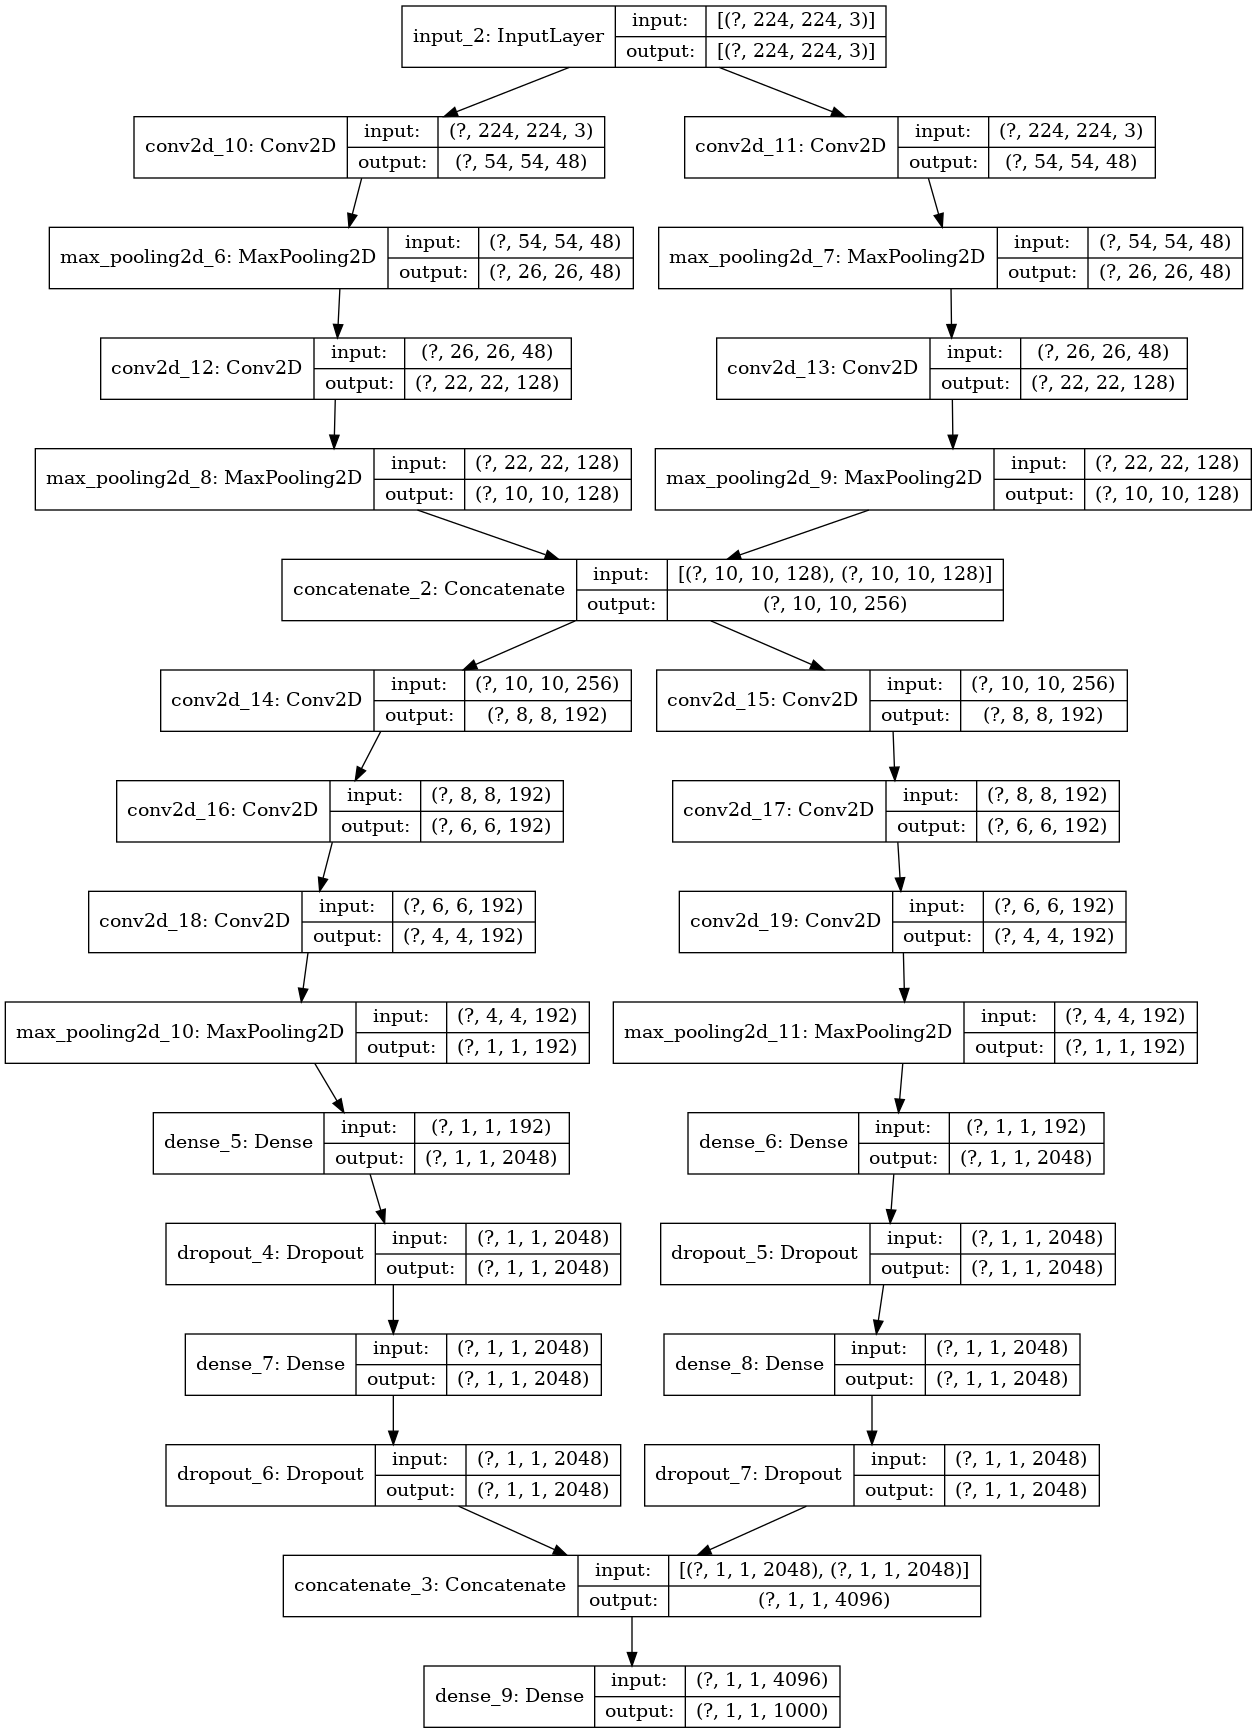

In [11]:
keras.utils.plot_model(alexnet, show_shapes=True)

In [12]:
alexnet.save('alexnet_model')

INFO:tensorflow:Assets written to: alexnet_model/assets
